In [1]:
import pandas as pd
import numpy as np
import json
import requests
%matplotlib inline
import random

In [2]:
#créé une liste des propositions, de solutions, d'enjeux, des scores
data = pd.read_csv('handi_alim_rgds_we_aines.csv', encoding='utf-8')
data = data[pd.notnull(data['keywordsvp2'])]
keywordsvp=list(data['keywordsvp2'])
props=list(data['content'])
solutions=list(data['solution_clean'])
print(len(props))

16680


In [3]:
zipped=zip(props,solutions,keywordsvp)
prop2solution2kw=list(zipped)
random.shuffle(prop2solution2kw)

In [ ]:
#d'abord avec tous ?
#mots clés significatifs (les plus visibles dans solutions) : interdire, arrêter, supprimer, taxer, sensibiliser, aider, éduquer, apprendre, informer
#solutions : sensibilisation et communication, régulation, aides et subventions, taxation, sanctions

#mots clés remarqués : éduquer, expliquer, sensibiliser, informer, promouvoir, enseigner, interdire, bannir, aider, privilégier, éviter, taxer, apprendre, réapprendre.

In [4]:
#zip props solutions, shuffle puis split en train/test
#prendre seulement ceux dont les solutions sont regroupables avec mots clés ?
from sklearn.model_selection import train_test_split
#corpus train/test
datatrain=prop2solution2kw[:11000]
datatest=prop2solution2kw[11000:]
X_train=[i for i,j,k in datatrain]
X_test=[i for i,j,k in datatest]
y_train=[j for i,j,k in datatrain]
y_test=[j for i,j,k in datatest]

In [6]:
import stop_words
stop_words_fr = stop_words.get_stop_words('fr')

In [7]:
stop_words_fr += ['il', 'faut', 'plus']

In [72]:
"""
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words=stop_words_fr)
X_train_f = tfidf.fit_transform(X_train)
#mat : prop x features(voc)
"""

In [8]:
#sans échantillon
#quand kws + tfidf ou kws seuls

#voc des keywords
voc=[]
#vpkeywords
train_kw=[k for i,j,k in datatrain]
test_kw=[k for i,j,k in datatest]
for kws in train_kw :
    voc.extend(kws.split('|'))
for kws in test_kw :
    try :
        voc.extend(kws.split('|'))
    except :
        pass
voc=list(set(voc))

X_train_kw=np.zeros((len(X_train),len(voc)))
for i in range(len(X_train)) :
    for word in voc :
        if word in train_kw[i].split('|') :
            X_train_kw[i,voc.index(word)]=1

In [9]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(fit_prior=False)
#normal
#nb.fit(X_train_f, y_train)

#en ajoutant features kws
#nb.fit(X_train_all, y_train)

#seulement avec features kws
nb.fit(X_train_kw, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)

In [74]:
#pas utilisé quand seulement features kws
#X_pred = tfidf.transform(X_test)

In [10]:
#quand kws + tfidf ou kws seuls
X_test_kw=np.zeros((len(X_test),len(voc)))
i=0
for i in range(len(X_test)) :
    for word in voc :
        try :
            if word in test_kw[i].split('|') :
                X_test_kw[i,voc.index(word)]=1
        except :
            #pas de keywords
            pass

In [11]:
#seulement tfidf 
#y_pred = nb.predict(X_pred)

#tfidf+kws
#y_pred = nb.predict(X_test_all)

#seulement kws
y_pred=nb.predict(X_test_kw)

In [12]:
#seulement tfidf 
#y_proba=nb.predict_proba(X_pred)

#tfidf+kws
#y_proba = nb.predict_proba(X_test_all)

#seulement kws
y_proba=nb.predict_proba(X_test_kw)

In [13]:
classe2id={t:i for i,t in enumerate(nb.classes_) }
print(nb.classes_)

['RSE' 'accompagnement & coaching' 'action européenne'
 'aides et subventions' 'aménagement des espaces'
 'aménagement du territoire' 'budget et finances publiques'
 'comportements individuels' 'contrôle qualité'
 'coopération intergouvernementale' 'e-santé' 'harmonisation' 'insertion'
 'justice' 'orientation de politique générale' 'participation citoyenne'
 'protection environnementale' 'protectionnisme économique'
 'redistribution & répartition' 'responsabilisation'
 'réforme des politiques publiques' 'régulation'
 'régulation des comportements' 'sanctions' 'sanctions et contrôle'
 'sensibilisation et communication' 'simplification'
 'simplification administrative' 'solution non mentionnée'
 'sortie euro et Europe' 'taxation']


In [14]:
res=0
resbis=0
res2=0
for i in range(len(X_test)) :
    #print(X_test[i], ":", y_test[i], "=>", y_pred[i], y_proba[i][classe2id[y_pred[i]]], "\n")
    if(y_pred[i]==y_test[i]) :
        res+=1
    #if y_proba[i][classe2id[y_pred[i]]] <= 0.4 and  y_proba[i][classe2id[y_pred[i]]] >0.3 and  X_test[i] not in ignore :
    if y_proba[i][classe2id[y_pred[i]]] > 0.2  :
        resbis+=1
        #print(X_test[i], ":", y_test[i], "=>", y_pred[i], y_proba[i][classe2id[y_pred[i]]], "\n")

In [15]:
print(res/len(X_test)*100,'%')


#print(resbis/len(X_test)*100,'%')
#print(resbis)
#print(len(X_test))

40.71161048689139 %


In [16]:
rep=[]
for i in range(len(X_test)) :
    if y_proba[i][classe2id[y_pred[i]]] > 0.2 :
        #print(X_test[i], " => ", y_pred[i], y_proba[i][classe2id[y_pred[i]]], "\n")
        rep.append((X_test[i],y_pred[i]))
good=0
echantillon = random.sample(rep, 30) 
for prop,classe in echantillon : 
    print(prop,classe) 
    print("bien classé ? y/n")
    r=input()
    if r=='y' :
        good+=1
print(good/30*100)

Il faut des cours de cuisine au collège/ lycée pour que les jeunes réalisent qu'il est simple et économique de manger des plats faits maison comportements individuels
bien classé ? y/n
y
Il faut apprendre aux gens à cuisiner des plats sains et rapides sensibilisation et communication
bien classé ? y/n
y
Il faut généraliser les labels sur le mode d'élevage pour tous les produits animaux, informer sur le bien-être animal lié à la qualité ! sensibilisation et communication
bien classé ? y/n
y
Il faut manger à des heures régulières comportements individuels
bien classé ? y/n
y
Il faut promouvoir la relocalisation des productions sensibilisation et communication
bien classé ? y/n
y
Il faut taxer les produits et viandes pour les pays qui ne respectent pas les cycles (production intensive) et qualité. Détaxer les locaux taxation
bien classé ? y/n
y
Il faut manger de manière raisonnable et raisonnée. comportements individuels
bien classé ? y/n
y
Il faut des produits bruts, sains, non transform

In [111]:
wrong=0
for i in range(len(X_test)) :
    if(y_pred[i]!=y_test[i]) :
        print(X_test[i], ":", y_test[i], "=>", y_pred[i], y_proba[i][classe2id[y_pred[i]]], "\n")
        wrong+=1

Il faut l’accès au sport à tous. Chacun doit pouvoir pratiquer l’activité qui lui plaît, et s’y épanouir pleinement : autres => allocations et financier 0.4127218079616491 

Il faut éduquer la société à poser un regard tolérant, favoriser l’insertion, faciliter l’accueil familial des personnes avec un handicap : changement regard => travail 0.37724361418263996 

Il faut que la formation des personnes accompagnées et des personnels soient une priorité, afin de répondre à l'exigence d'inclusion sociale : travail => changement regard 0.2597915518897615 

Il faut envisager le bénévolat comme un levier d’inclusion sociale des personnes en situation de handicap : travail => autres 0.28429224759001875 

Il faut apprendre à créer ensemble les outils et l’accompagnement qui faciliteront l’accès au numérique pour tous : autres => travail 0.2583793317932029 

Il faut que chaque personne puisse avoir un moyen de communiquer afin de prendre part au monde, puisque c’est la base de notre existence : 

Il faut pour les handicapés comme moi qu'il y ait un SMIC et non 684 euros par mois : autres => allocations et financier 0.8595285054484876 

Il faut leur permettre de travailler partiellement pour ceux qui le veulent et le peuvent, sans baisser leur pension : travail => allocations et financier 0.5827272513911028 

Il faut assurer des campagnes de sensibilisation aux différentes formes de handicaps : changement regard => handicaps invisibles 0.49049824858500596 

Il faut faciliter l'inclusion des personnes handicapées dans le domaine de la culture, du tourisme et de l'audiovisuel : travail => éducation 0.40358242366861385 

Il faut former régulièrement les accompagnants et soignants aux bonnes postures, aux bonnes techniques, à l'utilisation des appareillages : travail => autres 0.19678794009981987 

Il faut des écoles professionnelles sur la PAO, DAO et codage pour les autistes qu'ils soient verbaux ou non verbaux : éducation => accessibilité et mobilité 0.20956735749643893 

Il faut

In [112]:
print(wrong)

308


In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
acc_score = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred, labels =nb.classes_)

print(acc_score)
print(conf_mat)

0.40711610486891386
[[  0   0   0   0   0   1   0   5   0   1   0   0   0   0   3   0   0   1
    0   0   0   2   0   0   0   2   0   0   3   0   2]
 [  0   0   0   2   1   0   0   0   0   2   0   0   0   0   3   0   0   0
    0   0   0   0   1   0   0   6   0   0   2   0   0]
 [  0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0
    0   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0  37   0   2   3  10   0   5   0   0   0   0   2   1   0   2
    0   0   3   2   0   0   0  20   0   0  13   1   2]
 [  1   0   1   0   8   1   0   1   1   6   0   0   1   0   3   1   1   0
    0   0   2   1   0   0   0   7   0   0   5   0   1]
 [  0   0   0   1   0   9   0   8   0   4   0   0   0   0   7   4   0   1
    1   0   0   5   0   0   0   5   0   0  10   0   0]
 [  0   0   0   0   0   0   1   2   1   4   0   0   0   0   0   0   0   0
    0   0   2   3   0   0   0   1   0   0   2   1   4]
 [  2   2   0   4   2   5   1 394   0  27   0   3   2   0   9   0   0   4
   

['RSE' 'accompagnement & coaching' 'action européenne'
 'aides et subventions' 'aménagement des espaces'
 'aménagement du territoire' 'budget et finances publiques'
 'comportements individuels' 'contrôle qualité'
 'coopération intergouvernementale' 'e-santé' 'harmonisation' 'insertion'
 'justice' 'orientation de politique générale' 'participation citoyenne'
 'protection environnementale' 'protectionnisme économique'
 'redistribution & répartition' 'responsabilisation'
 'réforme des politiques publiques' 'régulation'
 'régulation des comportements' 'sanctions' 'sanctions et contrôle'
 'sensibilisation et communication' 'simplification'
 'simplification administrative' 'solution non mentionnée'
 'sortie euro et Europe' 'taxation']


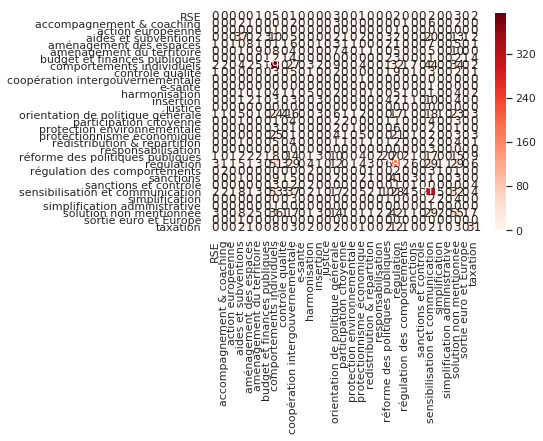

In [18]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
labels=nb.classes_
ax = sns.heatmap(conf_mat,annot=True,fmt="d",cmap="Reds",xticklabels=labels,yticklabels=labels)
print(nb.classes_)

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred,labels=nb.classes_))

                                   precision    recall  f1-score   support

                              RSE       0.00      0.00      0.00        20
        accompagnement & coaching       0.00      0.00      0.00        17
                action européenne       0.00      0.00      0.00         2
             aides et subventions       0.46      0.36      0.40       103
          aménagement des espaces       0.40      0.20      0.26        41
        aménagement du territoire       0.26      0.16      0.20        55
     budget et finances publiques       0.17      0.05      0.07        21
        comportements individuels       0.60      0.68      0.64       576
                 contrôle qualité       0.00      0.00      0.00        29
 coopération intergouvernementale       0.00      0.00      0.00         1
                          e-santé       0.00      0.00      0.00         1
                    harmonisation       0.22      0.17      0.19        29
                        

/home/piou/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/piou/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [20]:
def precision_recall(seuil,classe) :
    TP=0
    totalpredicted=0
    totalgold=0
    for i in range(len(X_test)) :
        if(y_test[i]==classe and y_proba[i][classe2id[classe]]>=seuil) :
            TP+=1
        if y_proba[i][classe2id[classe]]>=seuil :
            totalpredicted+=1
        if y_test[i]==classe :
            totalgold+=1
    """
    print(TP)
    print(totalpredicted-TP)#fp
    print(totalgold-TP)#fn
    """
    if totalpredicted==0 :
        precision=1
    else :
        precision=TP/totalpredicted
    recall=TP/totalgold
    return precision,recall

In [21]:
#evaluation
#1 si bonne classe 0 sinon 
def precision_recall_all(seuil) : 
    TP=0
    totalgold=0
    totalpredict=0
    for i in range(len(X_test)) :
        if(y_pred[i]==y_test[i] and y_proba[i][classe2id[y_test[i]]]>=seuil) :
            TP+=1
        if y_proba[i][classe2id[y_pred[i]]]>=seuil :
            totalpredict+=1
        if(y_pred[i]==y_test[i]) :
            totalgold+=1
    if totalpredict==0 : 
        precision=0
    else :
        precision = TP/totalpredict
    rappel=TP/totalgold
    return precision, rappel, seuil

In [125]:
print(precision_recall_all(0.6))

(1.0, 0.06285714285714286, 0.6)


In [22]:
import numpy as np
import matplotlib.pyplot as plt
prec_recall_seuil=[]
for seuil in np.arange(0,1,0.05) :
    prec_recall_seuil.append(precision_recall_all(seuil))
print(prec_recall_seuil)

[(0.40711610486891386, 1.0, 0.0), (0.6187464059804485, 0.9898804047838087, 0.05), (0.7671875, 0.9034038638454461, 0.1), (0.8547169811320755, 0.8334866605335787, 0.15000000000000002), (0.9165727170236753, 0.7479300827966882, 0.2), (0.9505208333333334, 0.671573137074517, 0.25), (0.9707602339181286, 0.6108555657773689, 0.30000000000000004), (0.9840255591054313, 0.5666973321067157, 0.35000000000000003), (0.9897084048027445, 0.53081876724931, 0.4), (0.9979674796747967, 0.45170193192272307, 0.45), (1.0, 0.39466421343146274, 0.5), (1.0, 0.3265869365225391, 0.55), (1.0, 0.2980680772769089, 0.6000000000000001), (1.0, 0.20423183072677092, 0.65), (1.0, 0.16835326586936522, 0.7000000000000001), (1.0, 0.140754369825207, 0.75), (1.0, 0.1140754369825207, 0.8), (1.0, 0.09015639374425023, 0.8500000000000001), (1.0, 0.06531738730450783, 0.9), (1.0, 0.04139834406623735, 0.9500000000000001)]


In [24]:
for seuilprecis in np.arange(0.25,0.5,0.01) :
    print(precision_recall_all(seuilprecis))

(0.9505208333333334, 0.671573137074517, 0.25)
(0.9548472775564409, 0.6614535418583257, 0.26)
(0.963013698630137, 0.6467341306347746, 0.27)
(0.9654696132596685, 0.6430542778288868, 0.28)
(0.9686609686609686, 0.62557497700092, 0.29000000000000004)
(0.9707602339181286, 0.6108555657773689, 0.30000000000000004)
(0.9730538922155688, 0.5979760809567617, 0.31000000000000005)
(0.9756838905775076, 0.5906163753449862, 0.32000000000000006)
(0.9767441860465116, 0.5795768169273229, 0.33000000000000007)
(0.9810725552050473, 0.5722171113155474, 0.3400000000000001)
(0.9840255591054313, 0.5666973321067157, 0.3500000000000001)
(0.9838187702265372, 0.5593376264949402, 0.3600000000000001)
(0.9852459016393442, 0.5528978840846366, 0.3700000000000001)
(0.9849749582637729, 0.5427782888684453, 0.3800000000000001)
(0.9898132427843803, 0.5363385464581417, 0.3900000000000001)
(0.9897084048027445, 0.53081876724931, 0.40000000000000013)
(0.9907235621521335, 0.49126034958601655, 0.41000000000000014)
(0.99246704331450

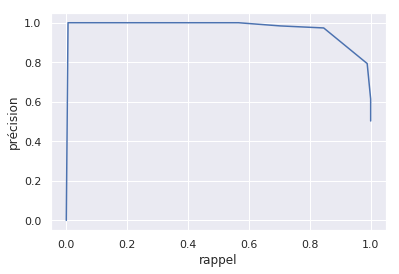

In [87]:
rappel=[rappel for precision,rappel,seuil in prec_recall_seuil]
precision=[precision for precision,rappel,seuil in prec_recall_seuil]
x = np.array(rappel)
y = np.array(precision)
plt.plot(x, y)
plt.xlabel("rappel")
plt.ylabel("précision")
plt.show()

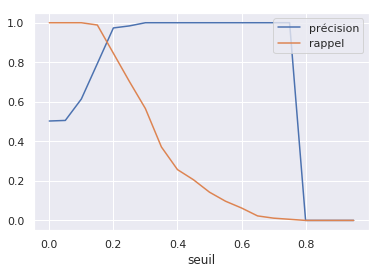

In [88]:
seuil=[i for i in np.arange(0,1,0.05)]
x = np.array(seuil)
y = np.array([precision for precision,rappel,seuil in prec_recall_seuil])
y2=np.array([rappel for precision,rappel,seuil in prec_recall_seuil])
plt.plot(x, y, label="précision")
plt.plot(x,y2,label="rappel")
plt.legend(loc='upper right')
plt.xlabel("seuil")
plt.show() # affiche la figure a l'ecran

In [28]:
print(precision_recall(0.3,"travail"))

(0.7272727272727273, 0.16666666666666666)


In [29]:
import numpy as np
import matplotlib.pyplot as plt
res=[]
seuil=[i for i in np.arange(0,1,0.05)]
for classe in nb.classes_ :
    res1=[]
    for i in np.arange(0,1,0.05) :
        res1.append(precision_recall(i,classe))
    res.append(res1)

accessibilité et mobilité


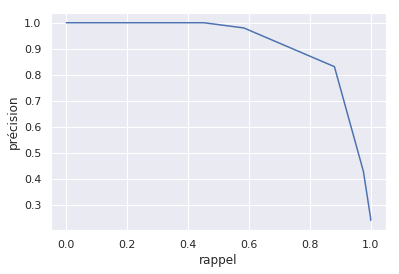

aidants


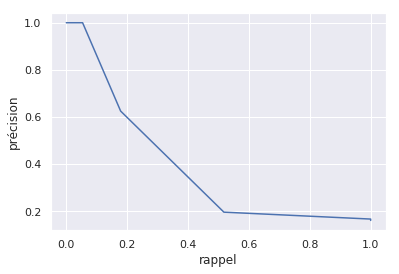

allocations et financier


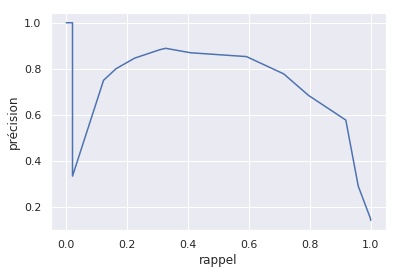

changement regard


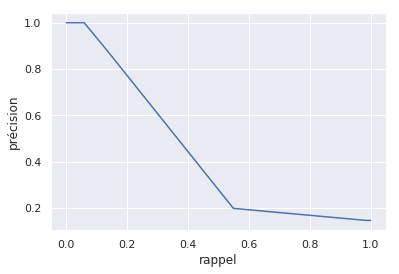

handicaps invisibles


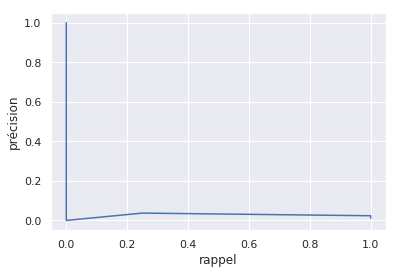

prise en charge


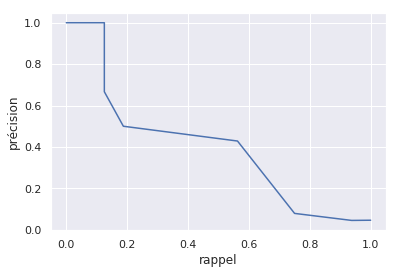

travail


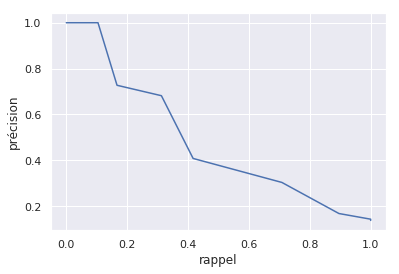

éducation


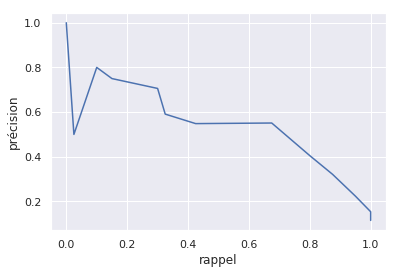

In [30]:
for i in range(len(nb.classes_)) :
    print(nb.classes_[i])
    rappel=[rappel for precision,rappel in res[i]]
    precision=[precision for precision,rappel in res[i]]
    x = np.array(rappel)
    y = np.array(precision)
    plt.plot(x, y)
    plt.xlabel("rappel")
    plt.ylabel("précision")
    plt.show()

accessibilité et mobilité


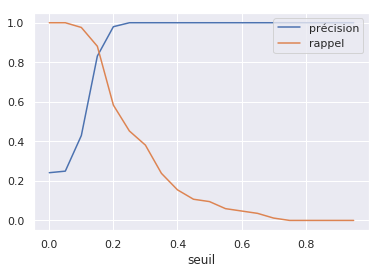

aidants


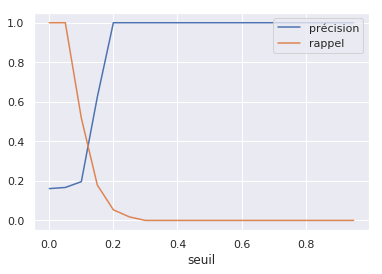

allocations et financier


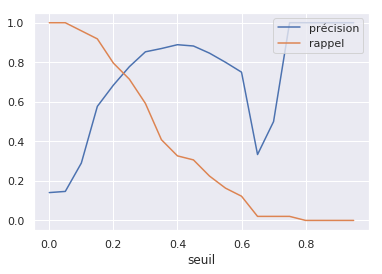

changement regard


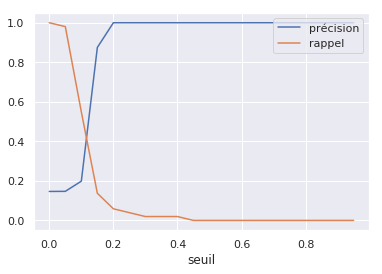

handicaps invisibles


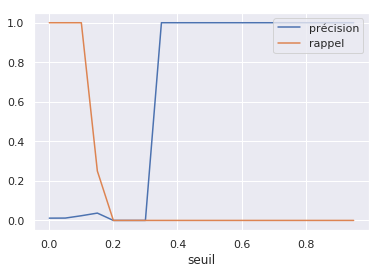

prise en charge


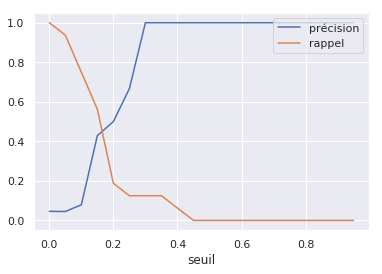

travail


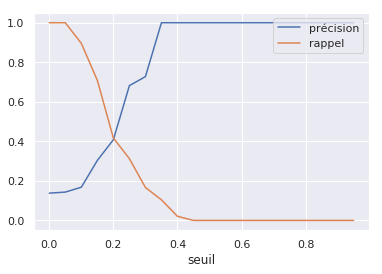

éducation


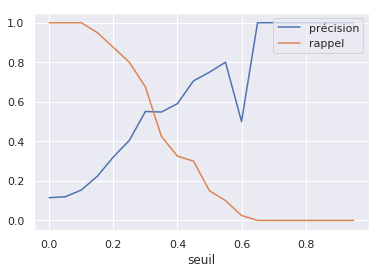

In [31]:
for i in range(len(nb.classes_)) :
    x = np.array(seuil)
    y = np.array([precision for precision,rappel in res[i]])
    y2=np.array([rappel for precision,rappel in res[i]])
    plt.plot(x, y, label="précision")
    plt.plot(x,y2,label="rappel")
    plt.legend(loc='upper right')
    plt.xlabel("seuil")
    print(nb.classes_[i])
    plt.show() # affiche la figure a l'ecran